In [10]:
import glob
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

from src import config

sb.set_theme()
path_to_test = "test_report"


def retrieve_transfer():
    full_results = []
    directory = path.join(path_to_test, "transfer", "*")

    for models_directory in glob.glob(directory):
        model, task, run_num = path.basename(models_directory).split("-")

        results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
        results["model"] = model
        results["task"] = task
        results["run_num"] = int(run_num)

        full_results.append(
            results[
                [
                    "model",
                    "task",
                    "run_num",
                    "source",
                    "balanced_accuracy",
                    "f1_0",
                    "f1_1",
                    "f1_2",
                ]
            ]
        )

    full_results = pd.concat(full_results)
    simple_res = full_results[full_results["source"] == "simple"]
    simple_res = simple_res.drop(columns="source")
    return simple_res.sort_values(
        ["model", "task", "run_num"], ascending=False
    ).reset_index(drop=True)


def retrieve_scratch():
    full_results = []
    directory = path.join(path_to_test, "scratch", "*")

    for models_directory in glob.glob(directory):
        model, run_num = (
            path.basename(models_directory).removesuffix(".ckpt").split("-")
        )

        results = pd.read_csv(path.join(models_directory, "mrart_recap.csv"))
        results["model"] = model
        results["run_num"] = int(run_num)

        full_results.append(
            results[
                [
                    "model",
                    "run_num",
                    "source",
                    "balanced_accuracy",
                    "f1_0",
                    "f1_1",
                    "f1_2",
                ]
            ]
        )

    full_results = pd.concat(full_results)
    simple_scratch = full_results[full_results["source"] == "simple"]
    simple_scratch.sort_values("balanced_accuracy", ascending=False)
    return simple_scratch


def retrieve_confidence(setting: str):
    conf_results = []
    directory = path.join(path_to_test, setting, "*")

    for models_directory in glob.glob(directory):
        if setting == "transfer":
            model, task, run_num = path.basename(models_directory).split("-")
        else:
            model, run_num = (
                path.basename(models_directory).removesuffix(".ckpt").split("-")
            )
            task = ""

        results = pd.read_csv(path.join(models_directory, "confidence.csv"))

        for thresh in np.linspace(0.5, 0.99, 50):
            selected_row = results[
                results["threshold_confidence"] > (thresh - 1e-4)
            ].iloc[0]
            conf_results.append(
                [
                    model,
                    int(run_num),
                    task,
                    selected_row["threshold_confidence"],
                    selected_row["balanced_accuracy"],
                    selected_row["kept_proportion"],
                ]
            )

    conf_results = pd.DataFrame(
        conf_results,
        columns=[
            "model",
            "run_num",
            "task",
            "source",
            "balanced_accuracy",
            "kept_proportion",
        ],
    )
    return conf_results


scratch_df = retrieve_confidence("scratch")
transfer_df = retrieve_confidence("transfer")
transfer_df = transfer_df[transfer_df["task"] != "CONTINUAL_MOTION"]

## Confidence Plots

(0.3, 1.05)

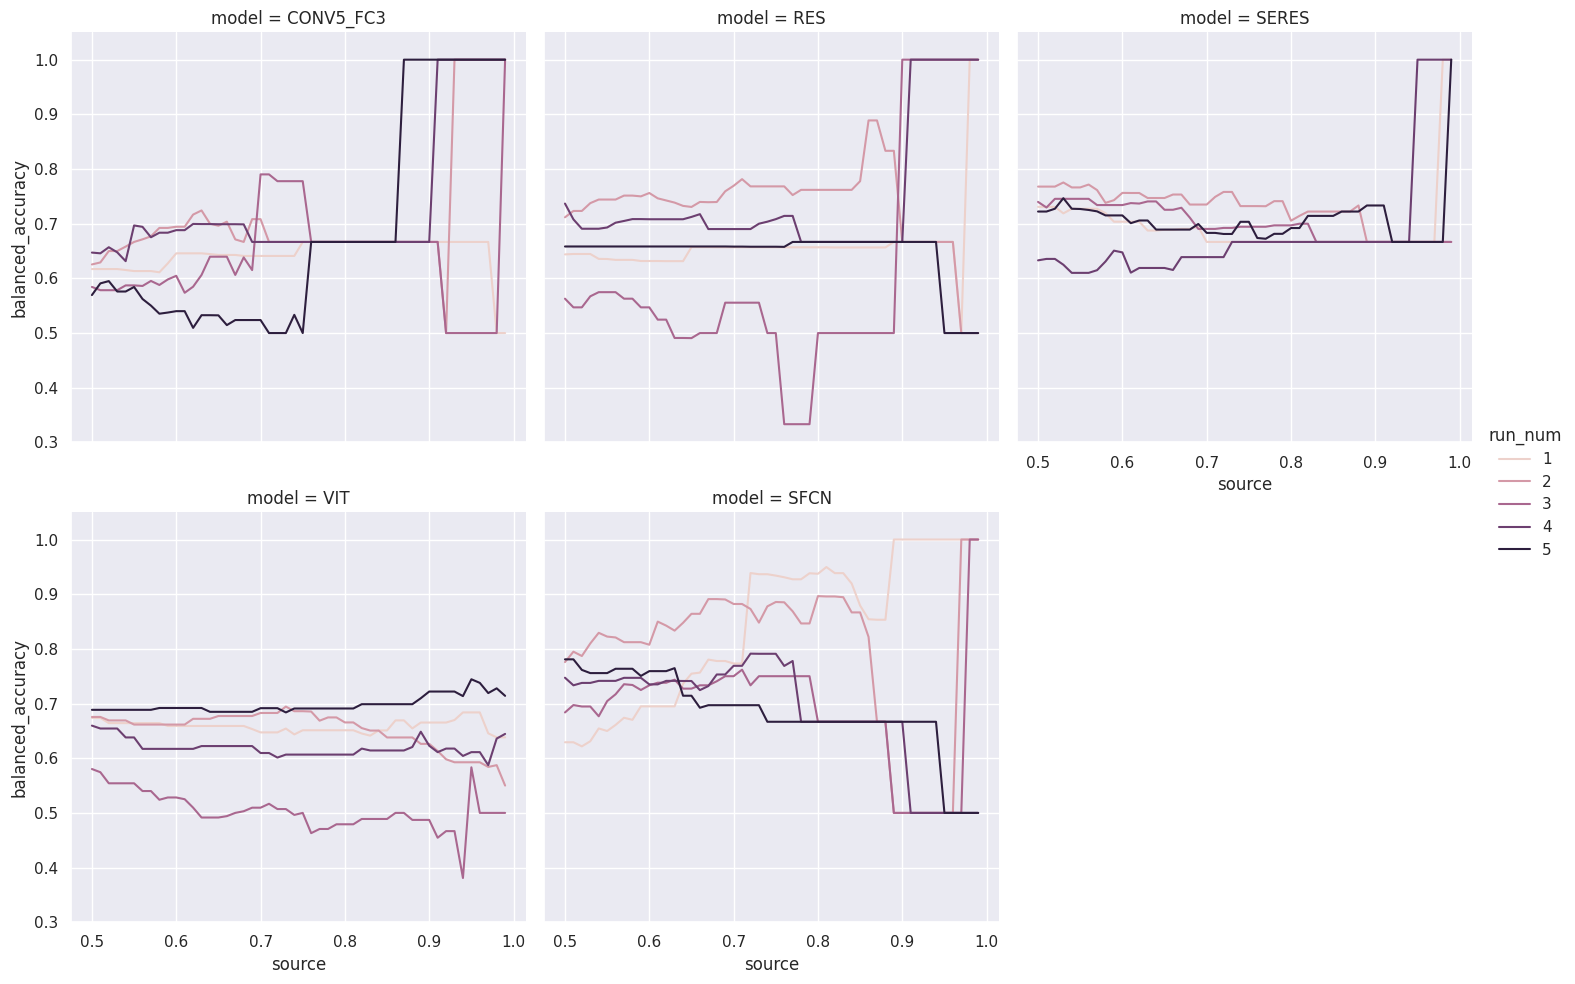

In [4]:
scratch_df["id"] = scratch_df["model"] + "-" + scratch_df["run_num"].astype(str)
sb.relplot(
    scratch_df,
    y="balanced_accuracy",
    x="source",
    estimator=None,
    hue="run_num",
    col="model",
    col_wrap=3,
    kind="line",
)
plt.ylim((0.3, 1.05))

/tmp/ipykernel_2465729/3969830234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  task_df["id"] = task_df["model"] + "-" + task_df["task"].astype(str)


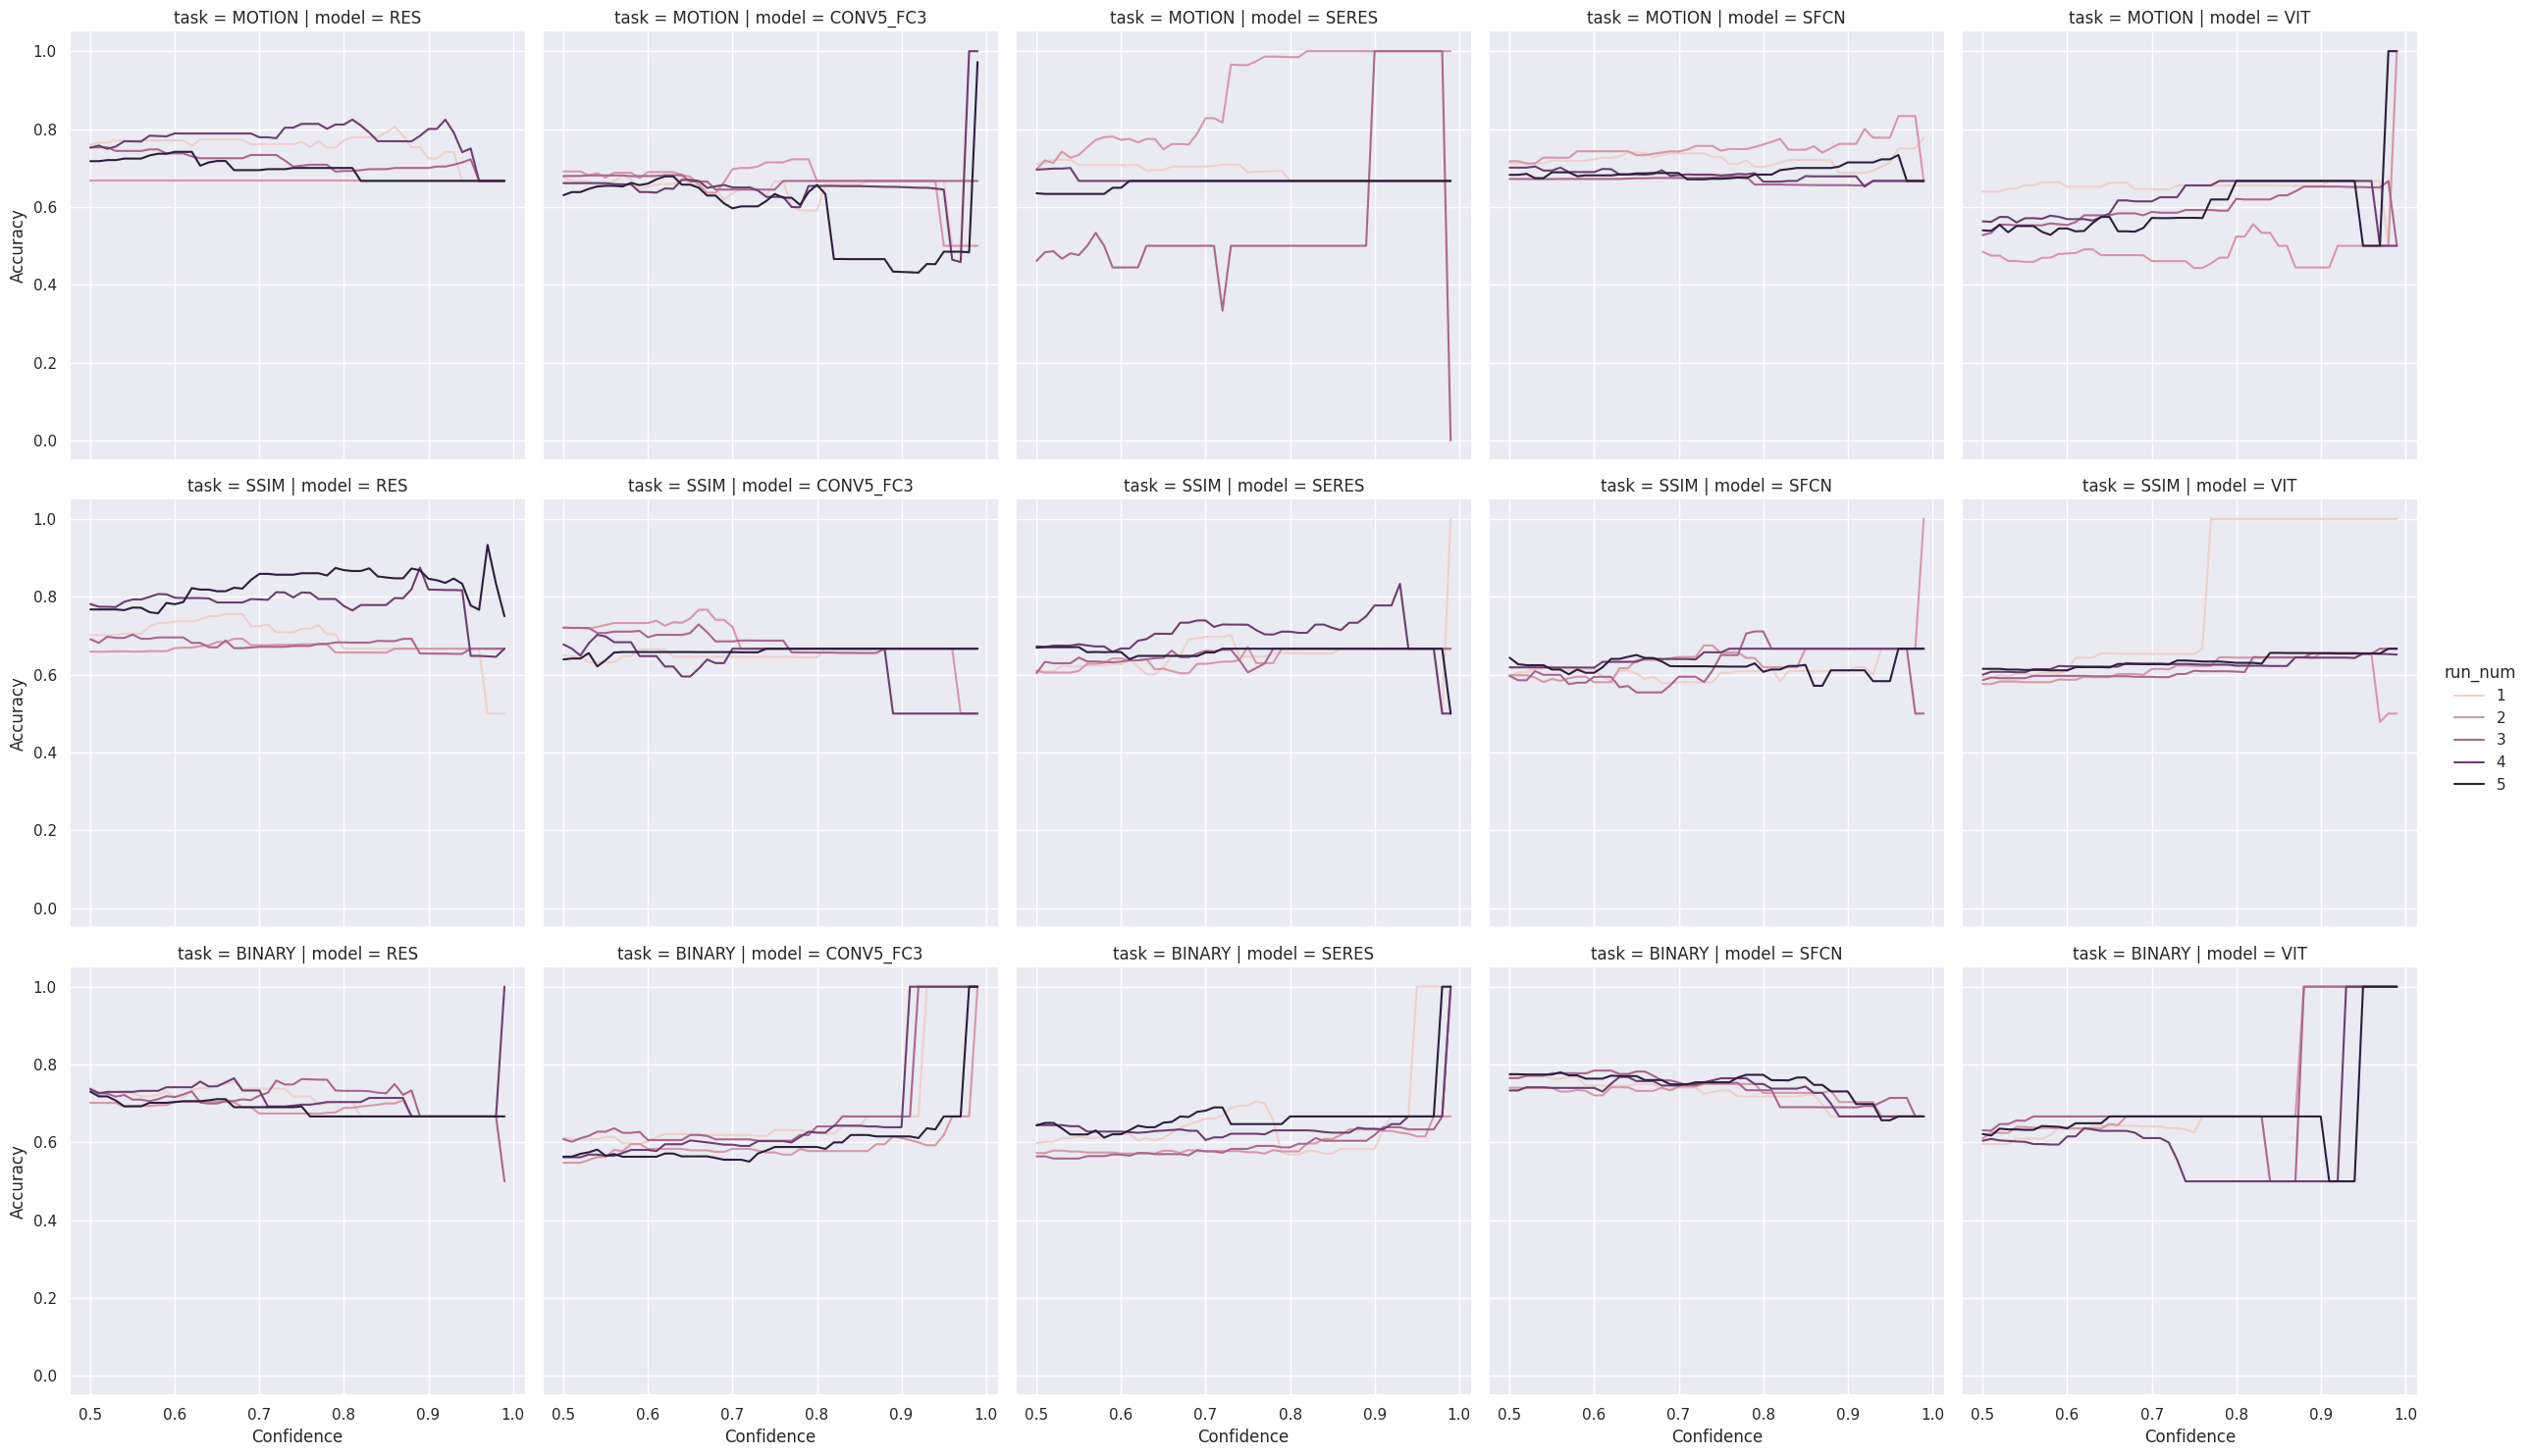

In [11]:
# %%
task_df = transfer_df[transfer_df["task"] != "SSIM"]
task_df["id"] = task_df["model"] + "-" + task_df["task"].astype(str)
fg = sb.relplot(
    transfer_df,
    y="balanced_accuracy",
    x="source",
    estimator=None,
    hue="run_num",
    col="model",
    row="task",
    kind="line",
)
fg.set_axis_labels("Confidence", "Accuracy")
# plt.ylim((0.3, 1.05))

## Confidence analysis

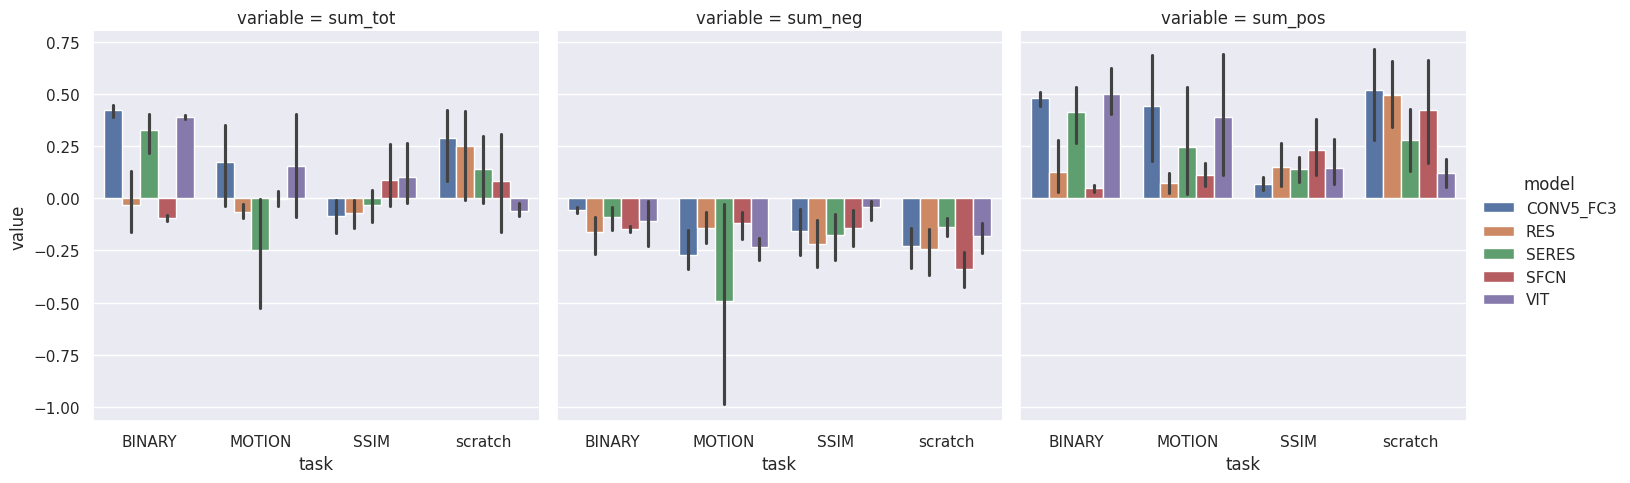

In [29]:
def compute_var(df: pd.DataFrame):
    def diff_max_min(serie):
        return serie.max() - serie.min()

    def diff_max_last(serie: pd.Series):
        return serie.iloc[-1] - serie.max()

    def pearson_conf(serie: pd.Series):
        coef = pearsonr(serie["balanced_accuracy"], serie["source"])

        return pd.Series({"correlation": coef.statistic, "p-value": coef.pvalue})

    def r2_conf(serie: pd.Series):
        coef = r2_score(serie["source"], serie["balanced_accuracy"])

        return pd.Series({"correlation": coef})

    def spearman_conf(serie: pd.Series):
        coef = spearmanr(serie["source"], serie["balanced_accuracy"])

        return pd.Series({"correlation": coef.statistic, "p-value": coef.pvalue})

    def sum_posneg_diff(serie):
        diff = np.diff(serie["balanced_accuracy"])
        pos_diff = np.where(diff > 0, diff, 0)
        neg_diff = np.where(diff < 0, diff, 0)

        return pd.Series(
            {
                "sum_pos": pos_diff.sum(),
                "sum_neg": neg_diff.sum(),
                "sum_tot": diff.sum(),
                "diff_max_min": diff_max_min(serie["balanced_accuracy"]),
            }
        )

    if "task" in df.columns:
        index = ["model", "task", "run_num"]
    else:
        index = ["model", "run_num"]

    return (
        df.sort_values(index + ["source"])
        .groupby(index, as_index=False)
        .apply(sum_posneg_diff)
    )


transfer_var_df = compute_var(transfer_df)
scratch_var_df = compute_var(scratch_df)
scratch_var_df["task"] = "scratch"
conc = pd.concat([transfer_var_df, scratch_var_df]).reset_index(drop=True)
conc = conc.melt(
    id_vars=["model", "run_num", "task"], value_vars=["sum_tot", "sum_neg", "sum_pos"]
)
sb.catplot(conc, y="value", hue="model", x="task", kind="bar", col="variable")

<Figure size 500x1000 with 0 Axes>

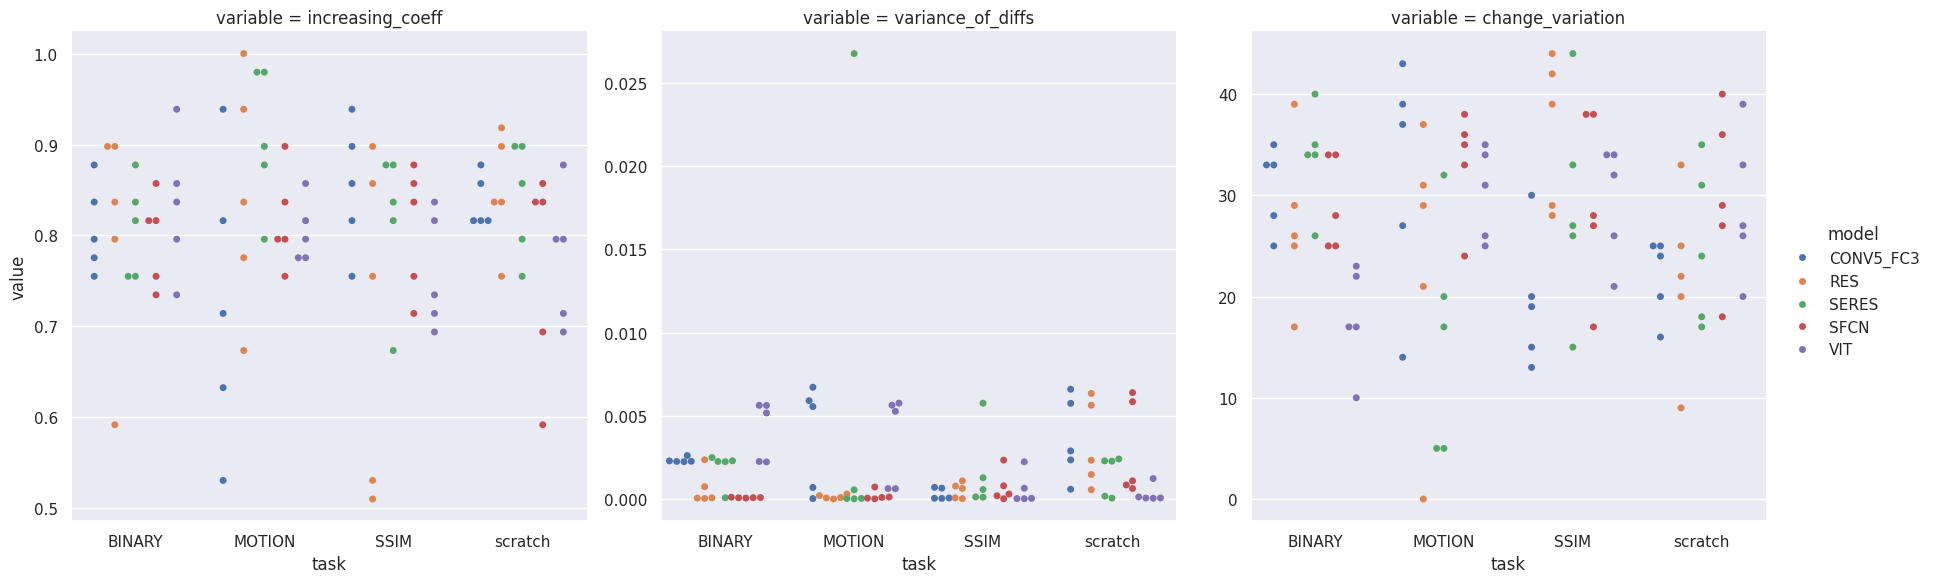

In [20]:
def compute_var(df: pd.DataFrame):

    def quality_quant(serie):
        diff = np.diff(serie["balanced_accuracy"])
        increasing_coeff = np.sum(diff >= 0) / len(diff)
        variance_of_diffs = np.var(diff)
        diff[diff == 0] = 1
        change_of_dir = np.sum(np.diff(diff) != 0)
        return pd.Series(
            {
                "increasing_coeff": increasing_coeff,
                "variance_of_diffs": variance_of_diffs,
                "change_variation": change_of_dir,
            }
        )

    if "task" in df.columns:
        index = ["model", "task", "run_num"]
    else:
        index = ["model", "run_num"]

    return (
        df.sort_values(index + ["source"])
        .groupby(index, as_index=False)
        .apply(quality_quant)
    )


transfer_var_df = compute_var(transfer_df)
scratch_var_df = compute_var(scratch_df)
scratch_var_df["task"] = "scratch"
conc = pd.concat([transfer_var_df, scratch_var_df]).reset_index(drop=True)
conc = conc.melt(
    id_vars=["model", "run_num", "task"],
    value_vars=["increasing_coeff", "variance_of_diffs", "change_variation"],
)

plt.figure(figsize=(5, 10))
sb.catplot(
    conc,
    y="value",
    hue="model",
    x="task",
    kind="swarm",
    col="variable",
    sharey=False,
    dodge=True,
    height=6,
    aspect=1,
)

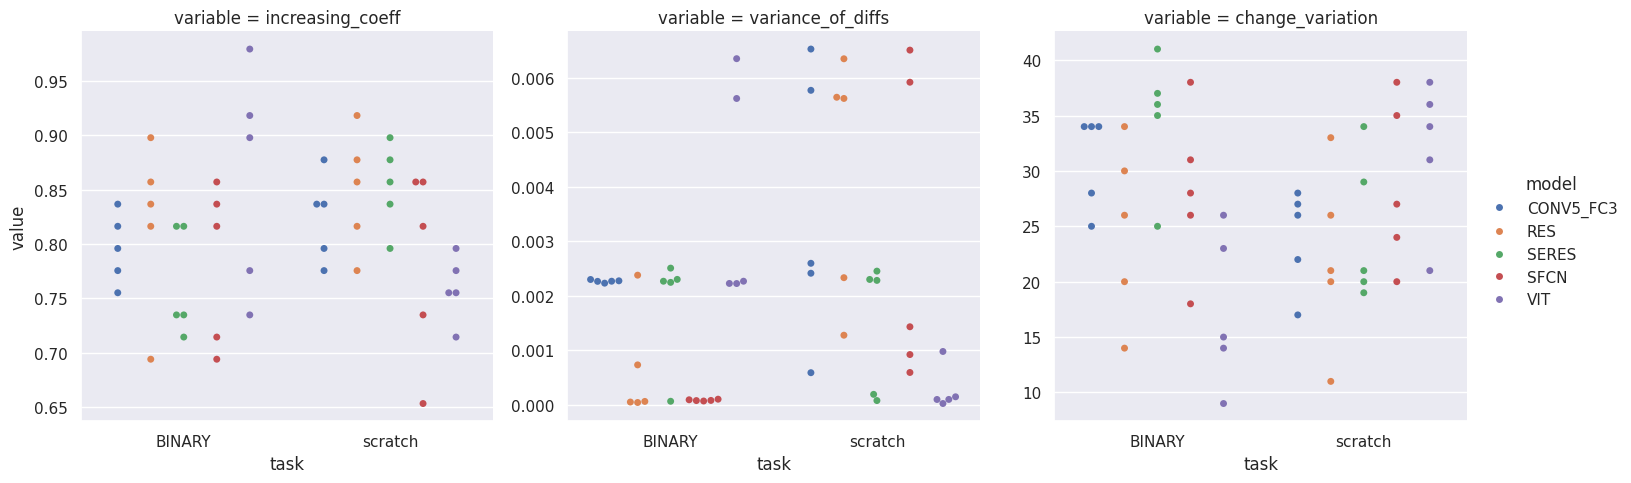

In [36]:
conc = conc[(conc["task"] != "MOTION") & (conc["task"] != "SSIM")]
sb.catplot(
    conc,
    y="value",
    hue="model",
    x="task",
    kind="swarm",
    col="variable",
    dodge=True,
    sharey=False,
)

/tmp/ipykernel_1361224/3972316761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current["diff"] = np.append(np.diff(current["balanced_accuracy"]), 0)
/tmp/ipykernel_1361224/3972316761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current["diff_2"] = np.append(np.diff(current["diff"]), 0)


-0.017094017094017033

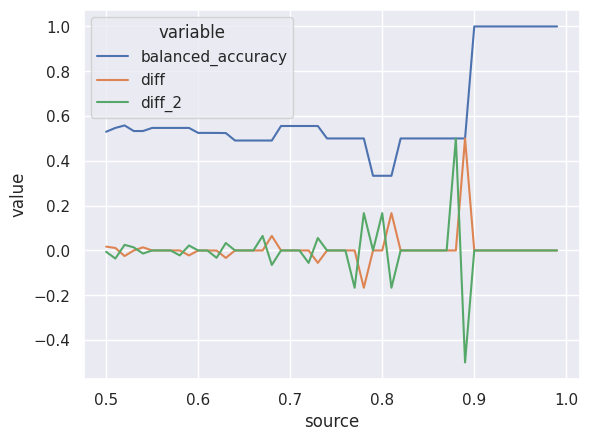

In [40]:
current = scratch_df[(scratch_df["model"] == "RES") & (scratch_df["run_num"] == 3)]
current["diff"] = np.append(np.diff(current["balanced_accuracy"]), 0)
current["diff_2"] = np.append(np.diff(current["diff"]), 0)

cur_melt = current.melt(
    id_vars=["id", "source"], value_vars=["balanced_accuracy", "diff", "diff_2"]
)
sb.lineplot(cur_melt, x="source", y="value", hue="variable")
current["diff_2"].sum()

# New analysis

In [58]:
def retrieve_confidence(setting: str):
    conf_results = []
    directory = path.join(path_to_test, setting, "*")

    for models_directory in glob.glob(directory):
        if setting == "transfer":
            model, task, run_num = path.basename(models_directory).split("-")
        else:
            model, run_num = (
                path.basename(models_directory).removesuffix(".ckpt").split("-")
            )
            task = ""

        results = pd.read_csv(path.join(models_directory, "confidence.csv"))

        for thresh in np.linspace(0, 1, 100):
            selected_row = results[
                results["threshold_confidence"] > (thresh - 1e-4)
            ].iloc[0]
            conf_results.append(
                [
                    model,
                    int(run_num),
                    task,
                    selected_row["threshold_confidence"],
                    selected_row["balanced_accuracy"],
                    selected_row["kept_proportion"],
                ]
            )

    conf_results = pd.DataFrame(
        conf_results,
        columns=[
            "model",
            "run_num",
            "task",
            "source",
            "balanced_accuracy",
            "kept_proportion",
        ],
    )
    return conf_results


scratch_df = retrieve_confidence("scratch")
transfer_df = retrieve_confidence("transfer")
transfer_df = transfer_df[transfer_df["task"] != "CONTINUAL_MOTION"]

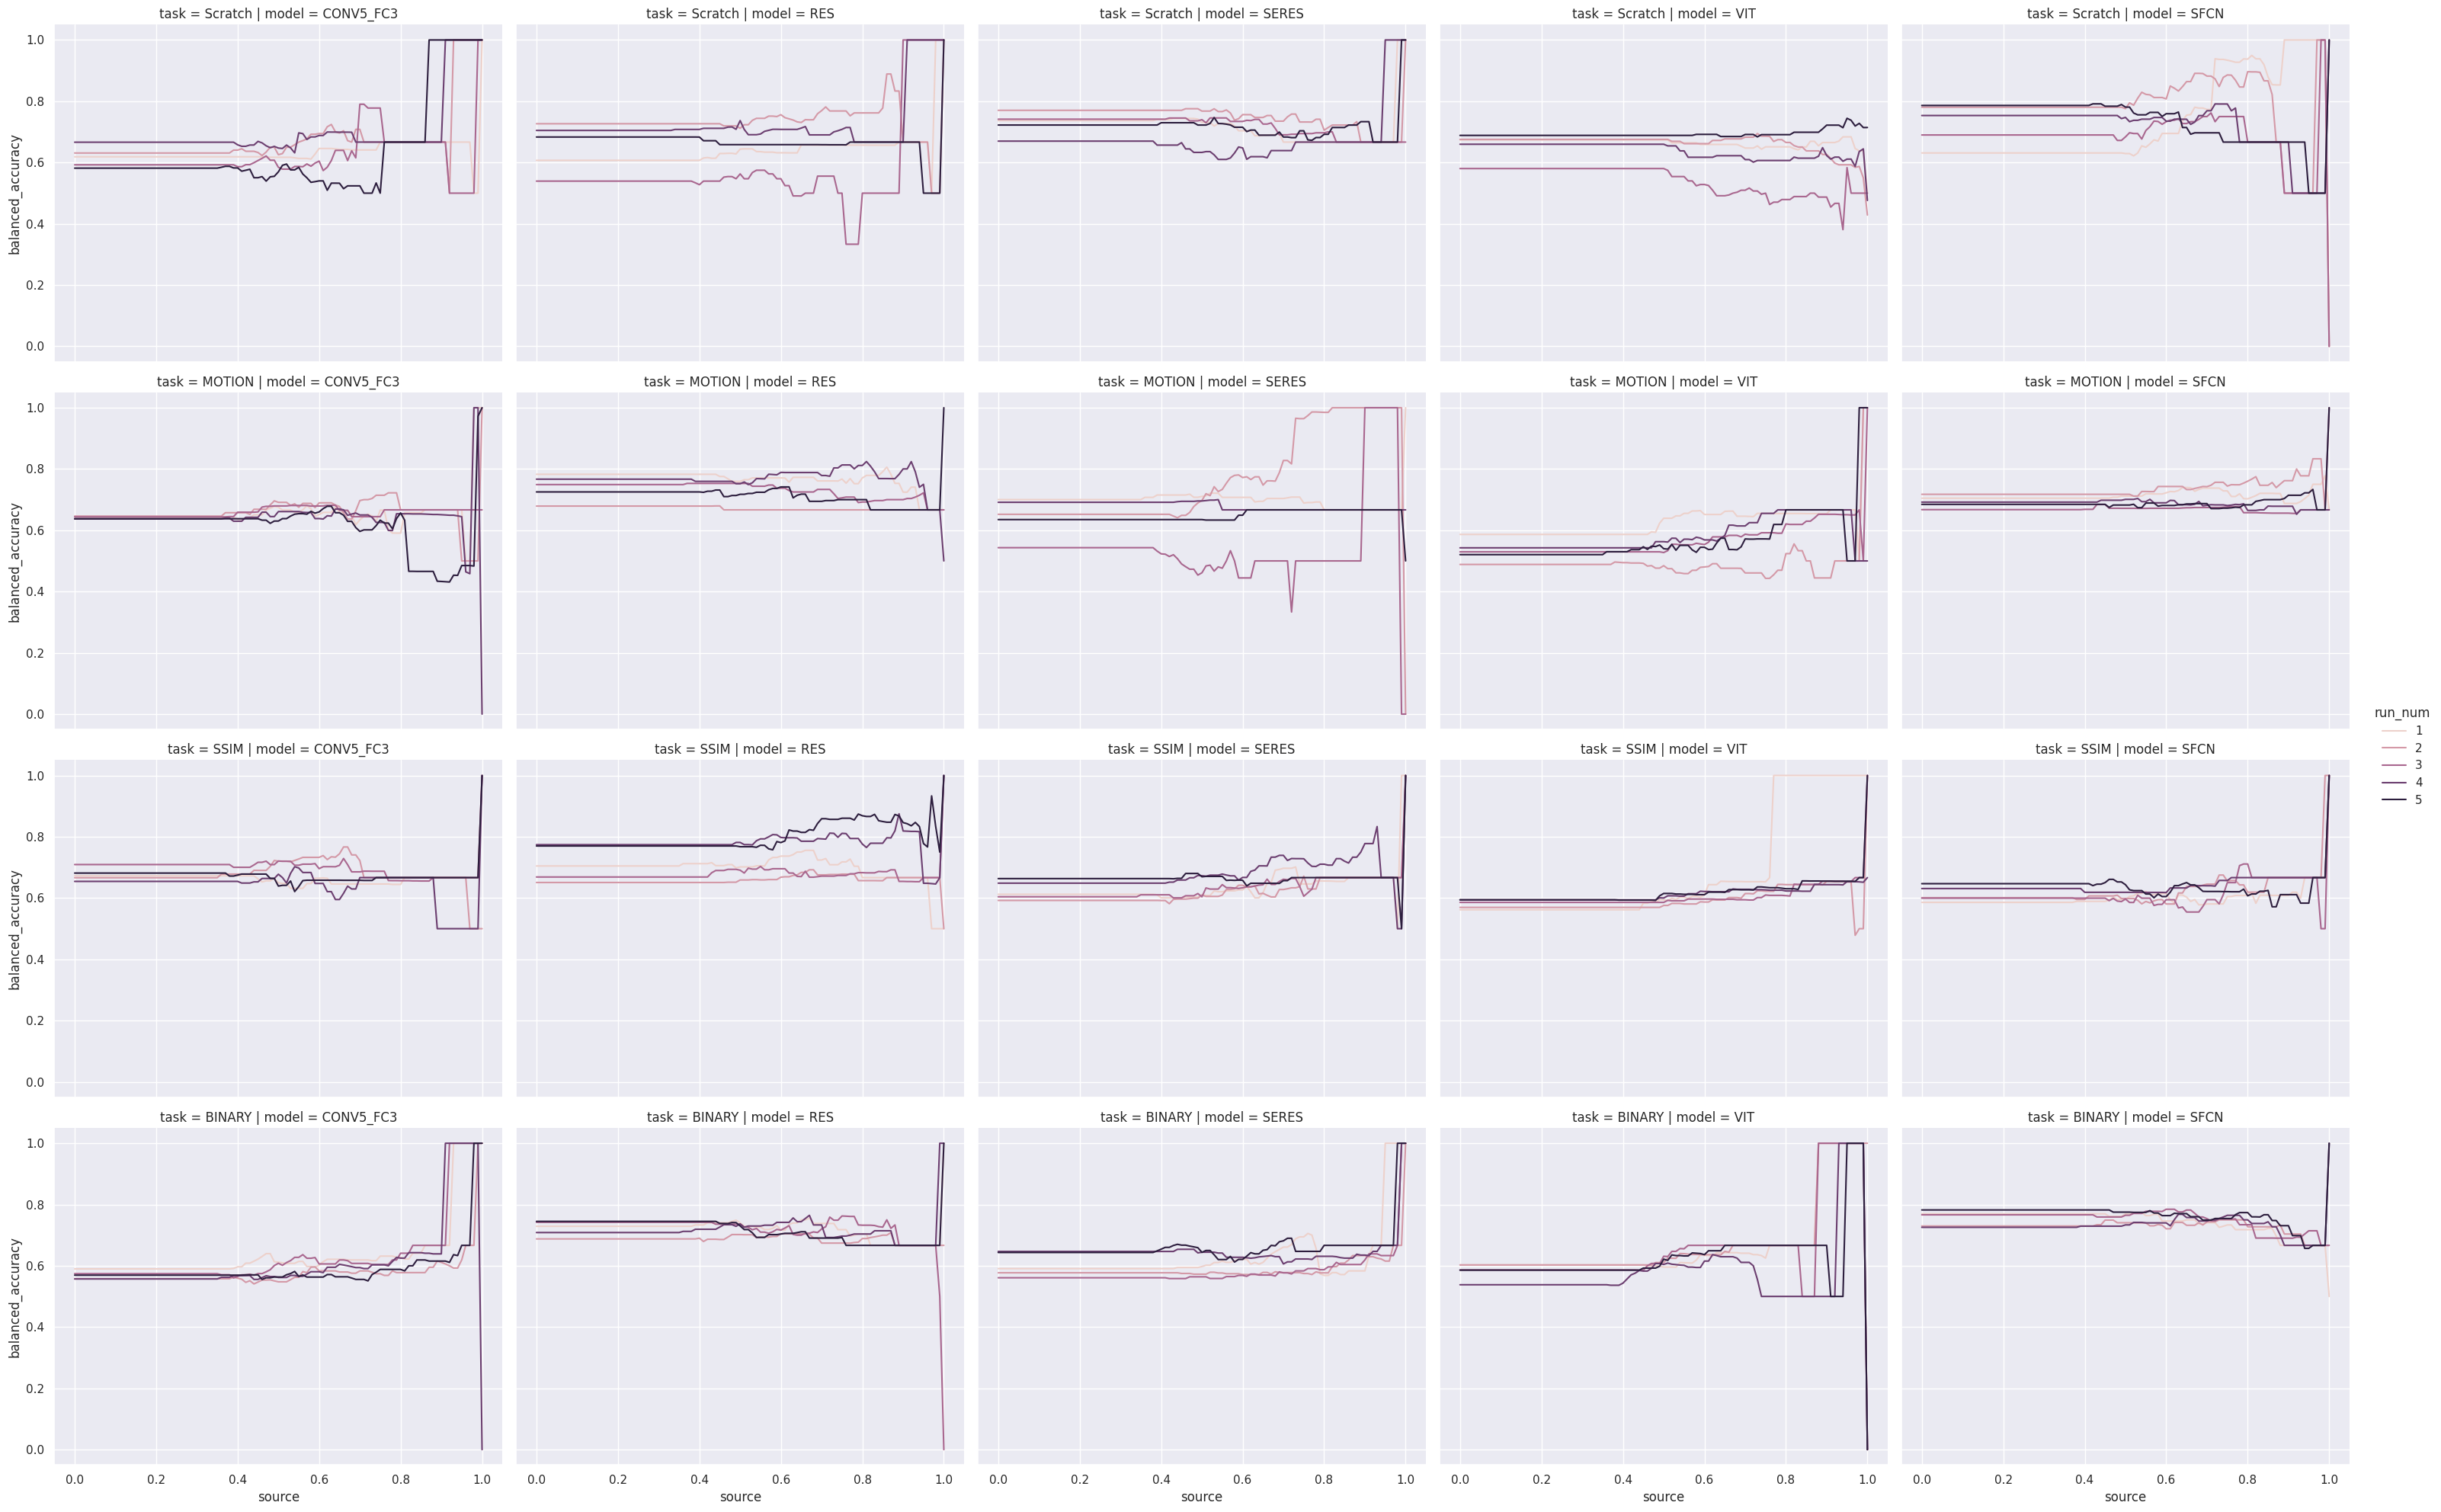

In [59]:
scratch_df["task"] = "Scratch"
concat = pd.concat([scratch_df, transfer_df])
sb.relplot(
    concat,
    kind="line",
    x="source",
    y="balanced_accuracy",
    hue="run_num",
    row="task",
    col="model",
    aspect=1.25,
)
plt.savefig("matrice.png", dpi=600)

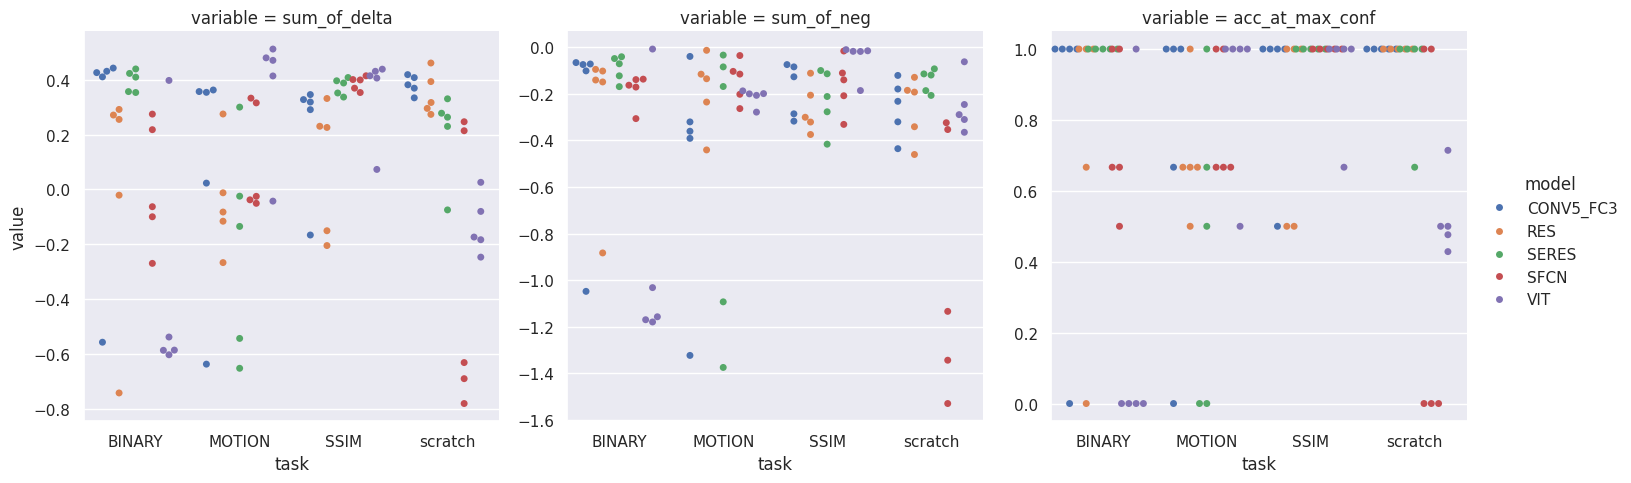

In [66]:
def compute_var(df: pd.DataFrame):

    def quality_quant(serie):
        diff = np.diff(serie["balanced_accuracy"])
        sum_of_delta = np.sum(diff)
        diff[diff == 0] = 1
        sum_of_neg = np.sum(np.where(diff < 0, diff, 0))
        acc_at_max_conf = serie["balanced_accuracy"].iloc[-1]
        prop_at_max_conf = serie["kept_proportion"].iloc[-1]

        ratio_max_conf = acc_at_max_conf / (1 - prop_at_max_conf)
        return pd.Series(
            {
                "sum_of_delta": sum_of_delta,
                "sum_of_neg": sum_of_neg,
                "acc_at_max_conf": acc_at_max_conf,
                "prop_at_max_conf": prop_at_max_conf,
            }
        )

    if "task" in df.columns:
        index = ["model", "task", "run_num"]
    else:
        index = ["model", "run_num"]

    return (
        df.sort_values(index + ["source"])
        .groupby(index, as_index=False)
        .apply(quality_quant)
    )


transfer_var_df = compute_var(transfer_df)
scratch_var_df = compute_var(scratch_df)
scratch_var_df["task"] = "scratch"
conc = pd.concat([transfer_var_df, scratch_var_df]).reset_index(drop=True)
conc_melt = conc.melt(
    id_vars=["model", "run_num", "task"],
    value_vars=["sum_of_delta", "sum_of_neg", "acc_at_max_conf"],
)
sb.catplot(
    conc_melt,
    y="value",
    hue="model",
    x="task",
    kind="swarm",
    col="variable",
    sharey=False,
    dodge=True,
)

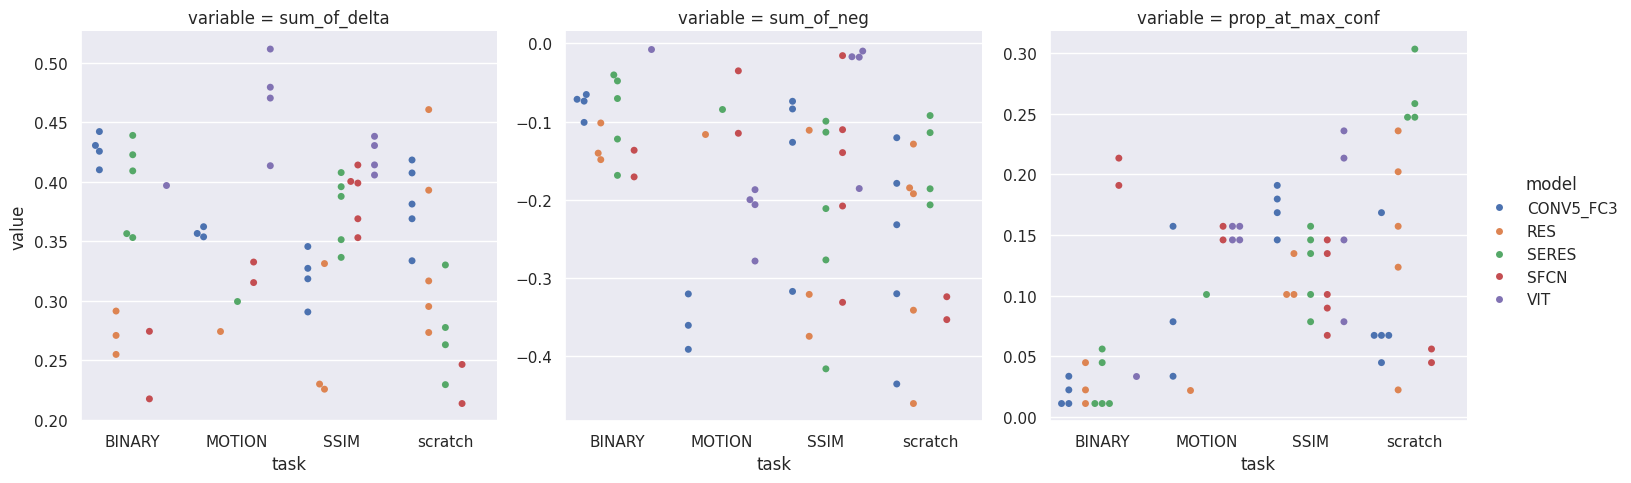

In [67]:
filt_conc = conc[conc["acc_at_max_conf"] == 1]
filt_conc_melt = filt_conc.melt(
    id_vars=["model", "run_num", "task"],
    value_vars=["sum_of_delta", "sum_of_neg", "prop_at_max_conf"],
)
sb.catplot(
    filt_conc_melt,
    y="value",
    hue="model",
    x="task",
    kind="swarm",
    col="variable",
    sharey=False,
    dodge=True,
)

In [62]:
filt_conc = conc[conc["acc_at_max_conf"] == 1]
filt_conc.groupby("task").count()

,model,run_num,sum_of_delta,sum_of_neg,acc_at_max_conf,prop_at_max_conf
task,,,,,,
BINARY,15,15,15,15,15,15
MOTION,11,11,11,11,11,11
SSIM,21,21,21,21,21,21
scratch,16,16,16,16,16,16


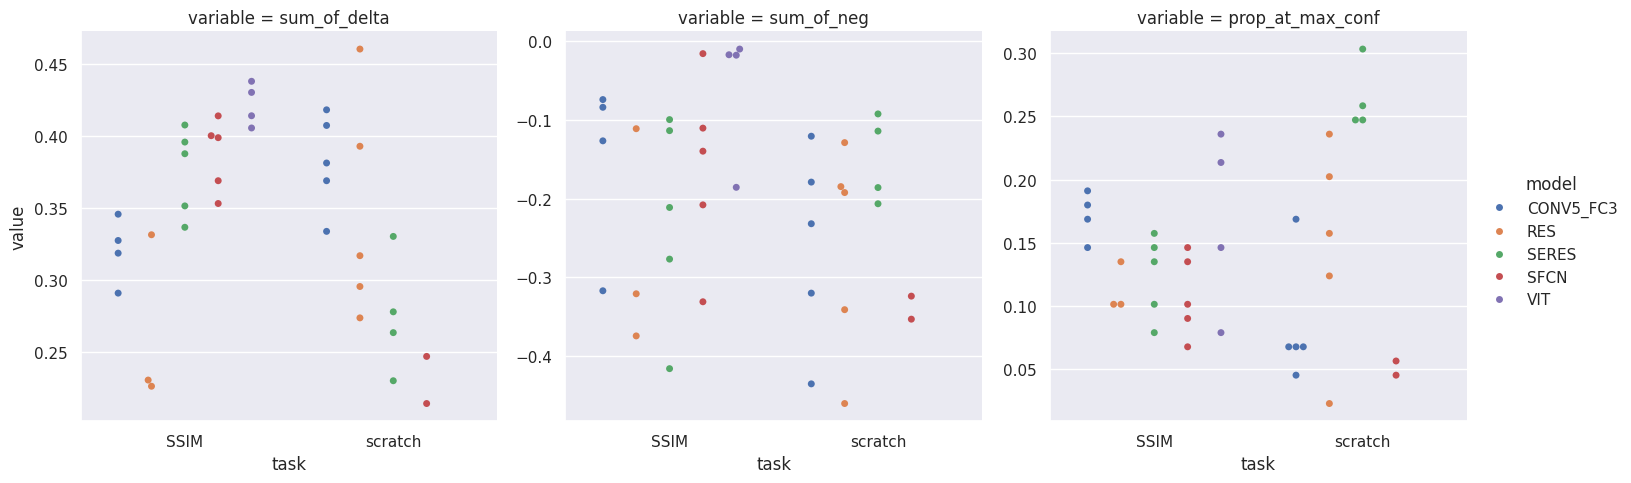

In [71]:
filtered_conc = conc[conc["acc_at_max_conf"] == 1]
conc_melt = filtered_conc.melt(
    id_vars=["model", "run_num", "task"],
    value_vars=["sum_of_delta", "sum_of_neg", "prop_at_max_conf"],
)
filtered_conc = conc_melt[
    (conc_melt["task"] == "SSIM") | (conc_melt["task"] == "scratch")
]

sb.catplot(
    filtered_conc,
    y="value",
    hue="model",
    x="task",
    kind="swarm",
    col="variable",
    sharey=False,
    dodge=True,
)

(0.25, 1.0)

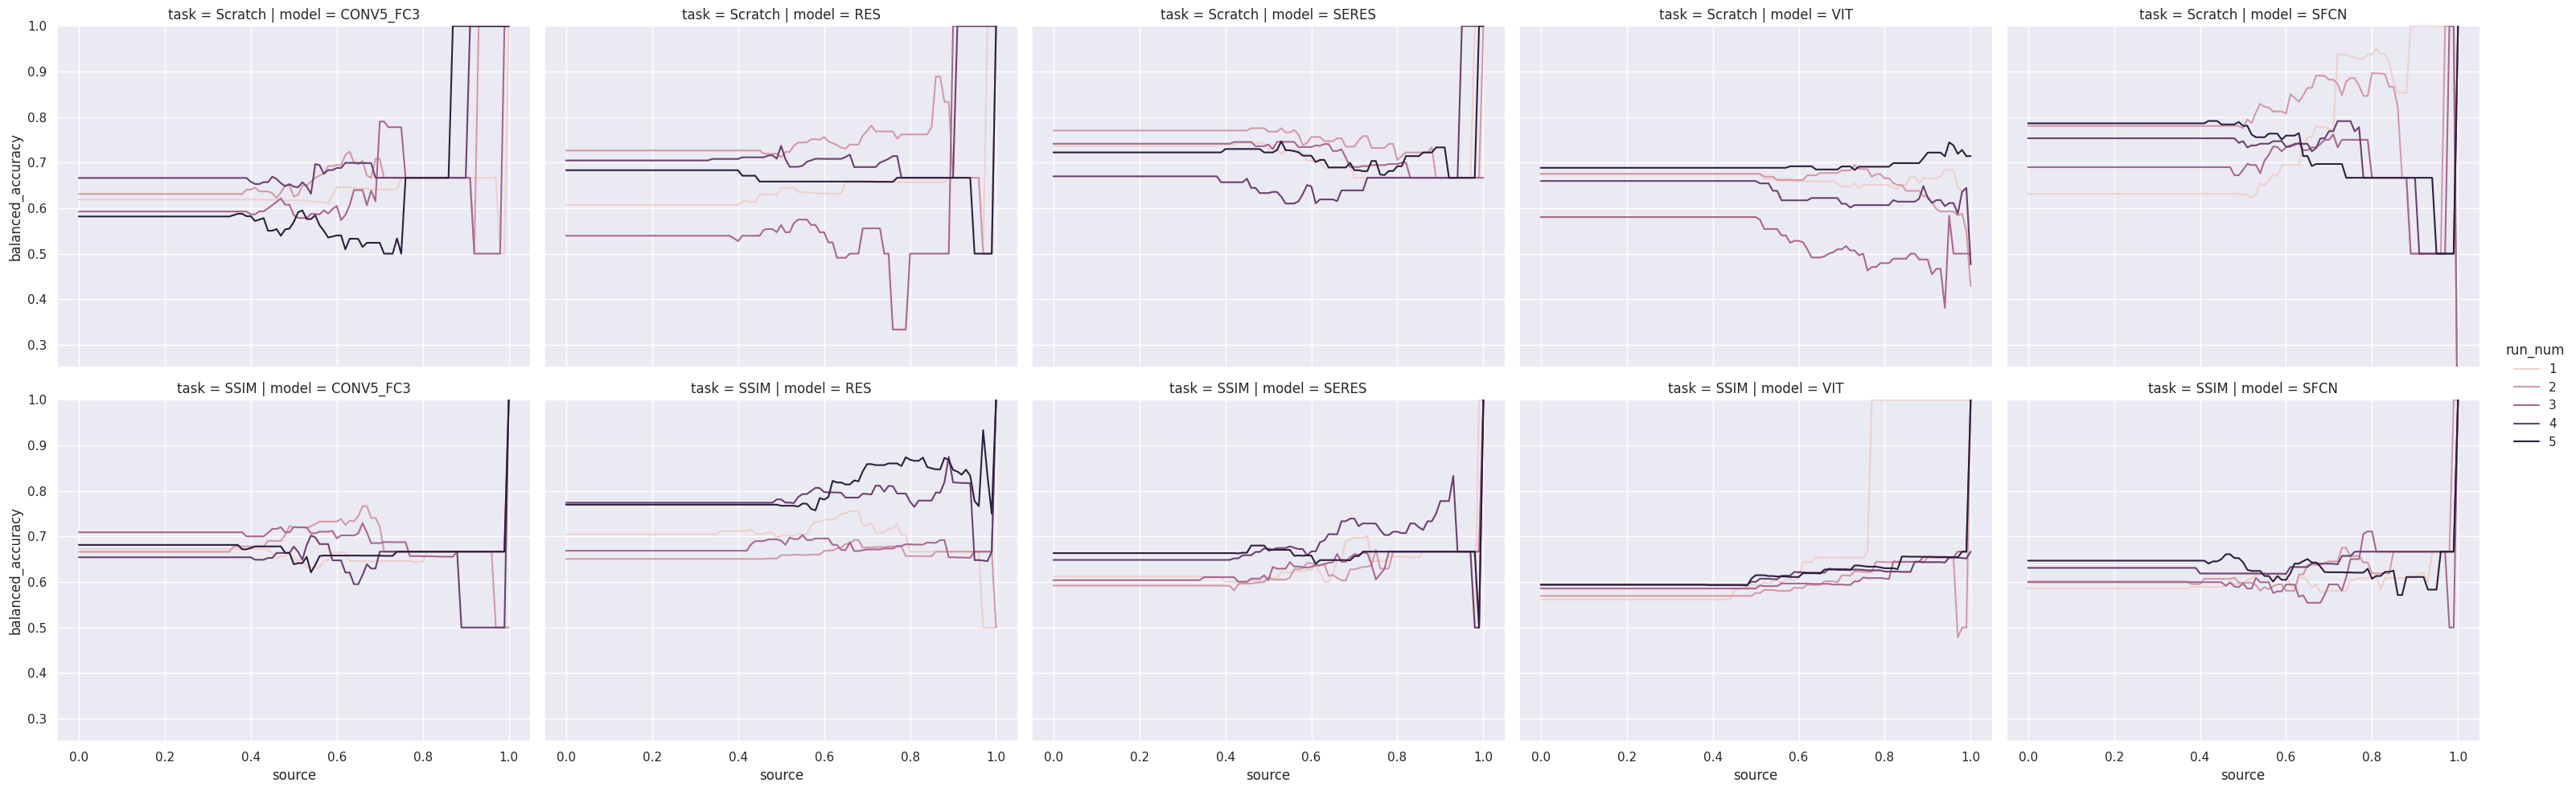

In [65]:
sb.relplot(
    concat[(concat["task"] == "SSIM") | (concat["task"] == "Scratch")],
    kind="line",
    x="source",
    y="balanced_accuracy",
    hue="run_num",
    row="task",
    col="model",
    aspect=1.25,
)
plt.ylim((0.25, 1))